<a href="https://colab.research.google.com/github/carvalheiracarlos/deep_leaning_notebooks/blob/main/imdb_cnn_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

In [4]:
'''
Probably need to merge this X_train and X_test, 
than partition again in some better proportion(train: 80% | test: 20%).

Fill review arrarys with zeros to have same lenght.
'''
print(f'Train Sets Shapes.....X_train: {X_train.shape}')
print(f'Train Sets Shapes.....y_train: {y_train.shape}')
print(f'Train Sets Largest Review Size: {max([max(review) for review in X_train])}')
print(f'Tests Sets Shapes.....X_test: {X_test.shape}')
print(f'Tests Sets Shapes.....y_test: {y_test.shape}')
print(f'Train Sets Largest Review Size: {max([max(review) for review in X_test])}')

Train Sets Shapes.....X_train: (25000,)
Train Sets Shapes.....y_train: (25000,)
Train Sets Largest Review Size: 9999
Tests Sets Shapes.....X_test: (25000,)
Tests Sets Shapes.....y_test: (25000,)
Train Sets Largest Review Size: 9999


In [5]:
X_train, X_val = X_train[:-5000], X_train[-5000:]
y_train, y_val = y_train[:-5000], y_train[-5000:]

In [7]:
maximum_sequence_length = 500 # maximum length of all review sequences
word_index = tf.keras.datasets.imdb.get_word_index()
word_index["<PAD>"] = 0

X_train = pad_sequences(X_train, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)
X_val = pad_sequences(X_val, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)
X_test = pad_sequences(X_test, value= word_index["<PAD>"], padding= 'post', maxlen= maximum_sequence_length)

print('X_train shape:', X_train.shape) # (n_samples, n_timesteps)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (20000, 500)
X_val shape: (5000, 500)
X_test shape: (25000, 500)


In [8]:
class ConvNet:
  @staticmethod
  def build(input_dim,
            embedding_dim,
            n_classes, 
            activation='relu', 
            weights_path=None):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(input_dim, embedding_dim, input_length=maximum_sequence_length))
    model.add(tf.keras.layers.Conv1D(filters=128, 
                                     kernel_size=4,
                                     strides=1,
                                     activation=activation))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dropout(0.5))
    '''
    model.add(tf.keras.layers.Conv1D(filters=256, 
                                     kernel_size=4,
                                     strides=1,
                                     activation=activation))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dropout(0.5))
    '''
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(0.09)))

    model.add(tf.keras.layers.Dense(n_classes, activation='sigmoid'))

    # if a weights path is supplied (inicating that the model was
    # pre-trained), then load the weights
    if weights_path is not None:
      model.load_weights(weights_path)
    
    return model

In [9]:
n_epochs = 100 
ini_learning_rate = 1e-4
batch_size=128

In [11]:
with tf.device('/device:GPU:0') as sess:
  train_model = ConvNet.build(input_dim=10000,
                              embedding_dim=16, 
                              n_classes=1, 
                              activation='relu', 
                              weights_path=None)
  
  opt = tf.keras.optimizers.Adam(learning_rate=ini_learning_rate,
                                beta_1=0.9, 
                                beta_2=0.999, 
                                epsilon=1e-08,
                                decay=ini_learning_rate)
  
  train_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                      optimizer=opt, 
                      metrics=[tf.keras.metrics.BinaryAccuracy()])
  
  train_model.summary()
  
  tensorboard = tf.keras.callbacks.TensorBoard('./logs/fit/',
                                            write_images=True)
  
  callbacks_list = [tensorboard]
  
  fit_history = train_model.fit(x=X_train,
                                y=y_train,
                                epochs=n_epochs,
                                validation_data=(X_val, y_val),
                                validation_freq=1,
                                batch_size=batch_size,
                                callbacks=callbacks_list,
                                verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 497, 128)          8320      
                                                                 
 batch_normalization (BatchN  (None, 497, 128)         512       
 ormalization)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 flatten (Flatten)           (None, 128)               0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


157/157 [==============================] - 5s 16ms/step - loss: 13.7489 - binary_accuracy: 0.4992 - val_loss: 11.4664 - val_binary_accuracy: 0.4974
Epoch 2/100
157/157 [==============================] - 2s 14ms/step - loss: 9.7202 - binary_accuracy: 0.5224 - val_loss: 8.1137 - val_binary_accuracy: 0.5750
Epoch 3/100
157/157 [==============================] - 2s 15ms/step - loss: 6.8722 - binary_accuracy: 0.5433 - val_loss: 5.7449 - val_binary_accuracy: 0.5878
Epoch 4/100
157/157 [==============================] - 2s 15ms/step - loss: 4.8533 - binary_accuracy: 0.6029 - val_loss: 4.0563 - val_binary_accuracy: 0.6580
Epoch 5/100
157/157 [==============================] - 2s 15ms/step - loss: 3.4267 - binary_accuracy: 0.6644 - val_loss: 2.8608 - val_binary_accuracy: 0.6648
Epoch 6/100
157/157 [==============================] - 2s 15ms/step - loss: 2.4407 - binary_accuracy: 0.6929 - val_loss: 2.0439 - val_binary_accuracy: 0.6952
Epoch 7/100
157/157 [==============================] - 2s 15ms

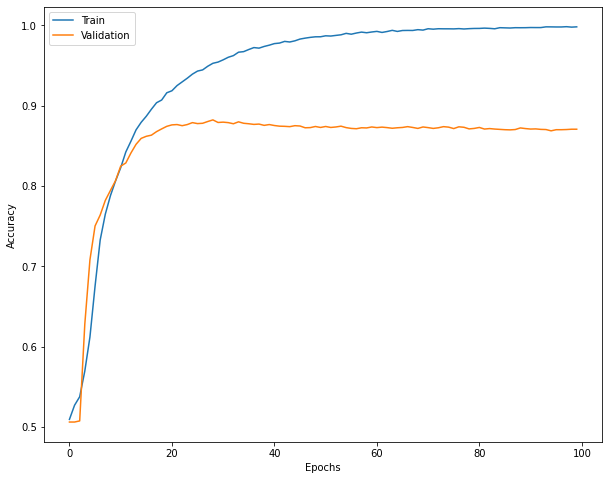

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = plt.plot(fit_history.history['binary_accuracy'], label='Train')
ax = plt.plot(fit_history.history['val_binary_accuracy'], label='Validation')
ax = plt.xlabel('Epochs')
ax = plt.ylabel('Accuracy')
ax = plt.legend()

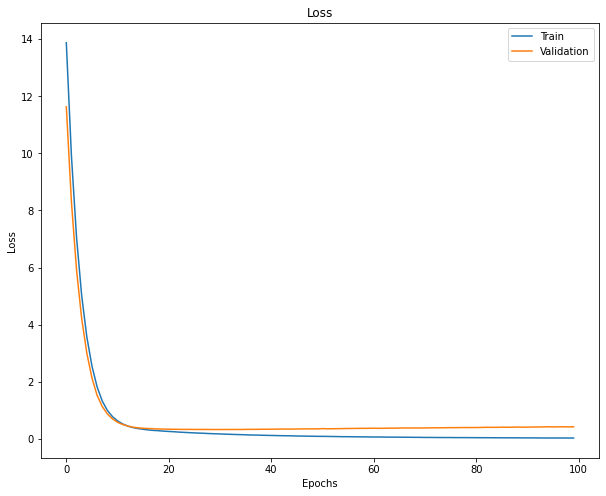

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = plt.plot(fit_history.history['loss'], label='Train')
ax = plt.plot(fit_history.history['val_loss'], label='Validation')
ax = plt.xlabel('Epochs')
ax = plt.ylabel('Loss')
ax = plt.title('Loss')
ax = plt.legend()

In [11]:
# Reference of Convolutional 1D Neural Network for imdb dataset
# https://bagheri365.github.io/blog/Sentiment-Analysis-of-IMDB-Movie-Reviews-using-Convolutional-Neural-Network-(CNN)-with-Hyperparameters-Tuning/